In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import os, sys, json, textwrap, math
import xgboost as xgb
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings("ignore")

In [2]:
OUT_DIR = Path("C:/Users/DELL/flask")  # change if needed
OUT_DIR.mkdir(parents=True, exist_ok=True)
file_path = "C:/Users/DELL/flask/financial_loan Datasets and Description__.xlsx"
print("Out dir:", OUT_DIR)


Out dir: C:\Users\DELL\flask


### Load sheets & quick overview

In [3]:
xls = pd.ExcelFile(file_path)
print("Sheets available:", xls.sheet_names)
# pick the best candidate sheet automatically
sheet_main = None
for s in xls.sheet_names:
    if "financial" in s.lower() or "loan" in s.lower():
        sheet_main = s
        break
if sheet_main is None:
    sheet_main = xls.sheet_names[0]
print("Using sheet:", sheet_main)
data = pd.read_excel(xls, sheet_name=sheet_main)
df = data.copy()
print("Shape:", df.shape)
df.head()

Sheets available: ['financial_loan Datasets and Des', 'Descriptions']
Using sheet: financial_loan Datasets and Des
Shape: (38576, 24)


,id,address_state,application_type,emp_length,emp_title,grade,home_ownership,issue_date,last_credit_pull_date,last_payment_date,...,sub_grade,term,verification_status,annual_income,dti,installment,int_rate,loan_amount,total_acc,total_payment
0,1077430,GA,INDIVIDUAL,< 1 year,Ryder,C,RENT,2021-11-02 00:00:00,13-09-2021,13-04-2021,...,C4,60 months,Source Verified,30000.0,0.0100,59.83,0.1527,2500,4,1009
1,1072053,CA,INDIVIDUAL,9 years,MKC Accounting,E,RENT,2021-01-01 00:00:00,14-12-2021,15-01-2021,...,E1,36 months,Source Verified,48000.0,0.0535,109.43,0.1864,3000,4,3939
2,1069243,CA,INDIVIDUAL,4 years,Chemat Technology Inc,C,RENT,2021-05-01 00:00:00,2021-12-12 00:00:00,2021-09-01 00:00:00,...,C5,36 months,Not Verified,50000.0,0.2088,421.65,0.1596,12000,11,3522
3,1041756,TX,INDIVIDUAL,< 1 year,barnes distribution,B,MORTGAGE,25-02-2021,2021-12-12 00:00:00,2021-12-03 00:00:00,...,B2,60 months,Source Verified,42000.0,0.0540,97.06,0.1065,4500,9,4911
4,1068350,IL,INDIVIDUAL,10+ years,J&J Steel Inc,A,MORTGAGE,2021-01-01 00:00:00,14-12-2021,15-01-2021,...,A1,36 months,Verified,83000.0,0.0231,106.53,0.0603,3500,28,3835


### Inspect columns, types, missing

In [4]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (38576, 24)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38576 entries, 0 to 38575
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     38576 non-null  int64  
 1   address_state          38576 non-null  object 
 2   application_type       38576 non-null  object 
 3   emp_length             38576 non-null  object 
 4   emp_title              37138 non-null  object 
 5   grade                  38576 non-null  object 
 6   home_ownership         38576 non-null  object 
 7   issue_date             38576 non-null  object 
 8   last_credit_pull_date  38576 non-null  object 
 9   last_payment_date      38576 non-null  object 
 10  loan_status            38576 non-null  object 
 11  next_payment_date      38576 non-null  object 
 12  member_id              38576 non-null  int64  
 13  purpose                38576 non-null  object 
 14  sub_grade              38576 non-null  object 
 15  te

### Data Cleaning & Type Conversion
We fix the data types. Dates are strings, and terms/employment lengths have text mixed with numbers.

In [6]:
def clean_loan_data(data):
    df_clean = data.copy()
    
    #  Date Conversion
    date_cols = ['issue_date', 'last_credit_pull_date', 'last_payment_date', 'next_payment_date']
    for col in date_cols:
        if col in df_clean.columns:
            df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')

    # Numeric Extraction from Strings
    # 'term' (e.g., " 36 months" -> 36)
    if 'term' in df_clean.columns:
        df_clean['term'] = df_clean['term'].astype(str).str.extract('(\d+)').astype(float)
    
    # 'emp_length' (e.g., "< 1 year" -> 0, "10+ years" -> 10)
    if 'emp_length' in df_clean.columns:
        df_clean['emp_length'] = df_clean['emp_length'].astype(str).str.extract('(\d+)').astype(float)
    
    return df_clean

df = clean_loan_data(df)

### Handling Missing Values

*Strategy:*
- 'emp_length': Missing likely means unemployed or self-employed without verification. Fill with 0.
- 'dti', 'annual_income': Critical financial metrics. If missing, fill with Median (robust to outliers).
- 'emp_title': High cardinality text. Fill with "Unknown".

A General strategy to deal with mising values for Categorical and numerical ariable in the dataset if they exist is using a combination of Mode for categorical features and Median for numerical features.

In [7]:
# missing summary
missing = df.isnull().sum().sort_values(ascending=False)
display(missing[missing>0].head(24))

emp_title    1438
dtype: int64

In [8]:
missing_percent = df.isnull().mean() * 100
print("Missing Value Percentage per Column:\n", missing_percent[missing_percent > 0])

# Execution
df['emp_length'].fillna(0, inplace=True)
df['emp_title'].fillna('Unknown', inplace=True)

# Note: Other numerical missing values (like total_acc) will be handled 
# by the SimpleImputer inside our ML pipeline later to prevent data leakage.
print("\nSpecific manual imputations complete.")

Missing Value Percentage per Column:
 emp_title    3.727706
dtype: float64

Specific manual imputations complete.


## Target creation

##### To Create Target Variable we must define "Bad" loan statuses
We are building a model to predict 'Approval' (Good Credit Risk).
- 1 = Approved (Fully Paid, Current)
- 0 = Rejected (Charged Off, Default)


In [9]:
good_status = ['Fully Paid', 'Current']
bad_status = ['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off']

# Filter only definitive rows
df= df[df['loan_status'].isin(good_status + bad_status)].copy()

# Create binary target
df['loan_approved'] = df['loan_status'].apply(lambda x: 1 if x in good_status else 0)

# Check for class imbalance
print("Target distribution:")
print(df['loan_approved'].value_counts(normalize=True))

Target distribution:
loan_approved
1    0.861753
0    0.138247
Name: proportion, dtype: float64


In [10]:
df['loan_status'].unique()

array(['Charged Off', 'Fully Paid', 'Current'], dtype=object)

Observation: There is a significant class imbalance (approx. 86% - 1 vs. 14% - 0). This will require careful model evaluation (e.g., using Recall and Precision).

## Robust Exploraatory Data Analysis

In [11]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ('id','member_id','target')]  # drop ID and Member ID
print("Numeric columns:", num_cols[:30])

# numeric summary
num_desc = df[num_cols].describe().T
display(num_desc)

Numeric columns: ['emp_length', 'term', 'annual_income', 'dti', 'installment', 'int_rate', 'loan_amount', 'total_acc', 'total_payment', 'loan_approved']


,count,mean,std,min,25%,50%,75%,max
emp_length,38576.0,5.093426,3.408560,1.0000,2.0000,4.0000,9.0000,1.000000e+01
term,38576.0,42.432393,10.630366,36.0000,36.0000,36.0000,60.0000,6.000000e+01
annual_income,38576.0,69644.540310,64293.681045,4000.0000,41500.0000,60000.0000,83200.5000,6.000000e+06
dti,38576.0,0.133274,0.066662,0.0000,0.0821,0.1342,0.1859,2.999000e-01
installment,38576.0,326.862965,209.092000,15.6900,168.4500,283.0450,434.4425,1.305190e+03
int_rate,38576.0,0.120488,0.037164,0.0542,0.0932,0.1186,0.1459,2.459000e-01
loan_amount,38576.0,11296.066855,7460.746022,500.0000,5500.0000,10000.0000,15000.0000,3.500000e+04
total_acc,38576.0,22.132544,11.392282,2.0000,14.0000,20.0000,29.0000,9.000000e+01
total_payment,38576.0,12263.348533,9051.104777,34.0000,5633.0000,10042.0000,16658.0000,5.856400e+04
loan_approved,38576.0,0.861753,0.345163,0.0000,1.0000,1.0000,1.0000,1.000000e+00


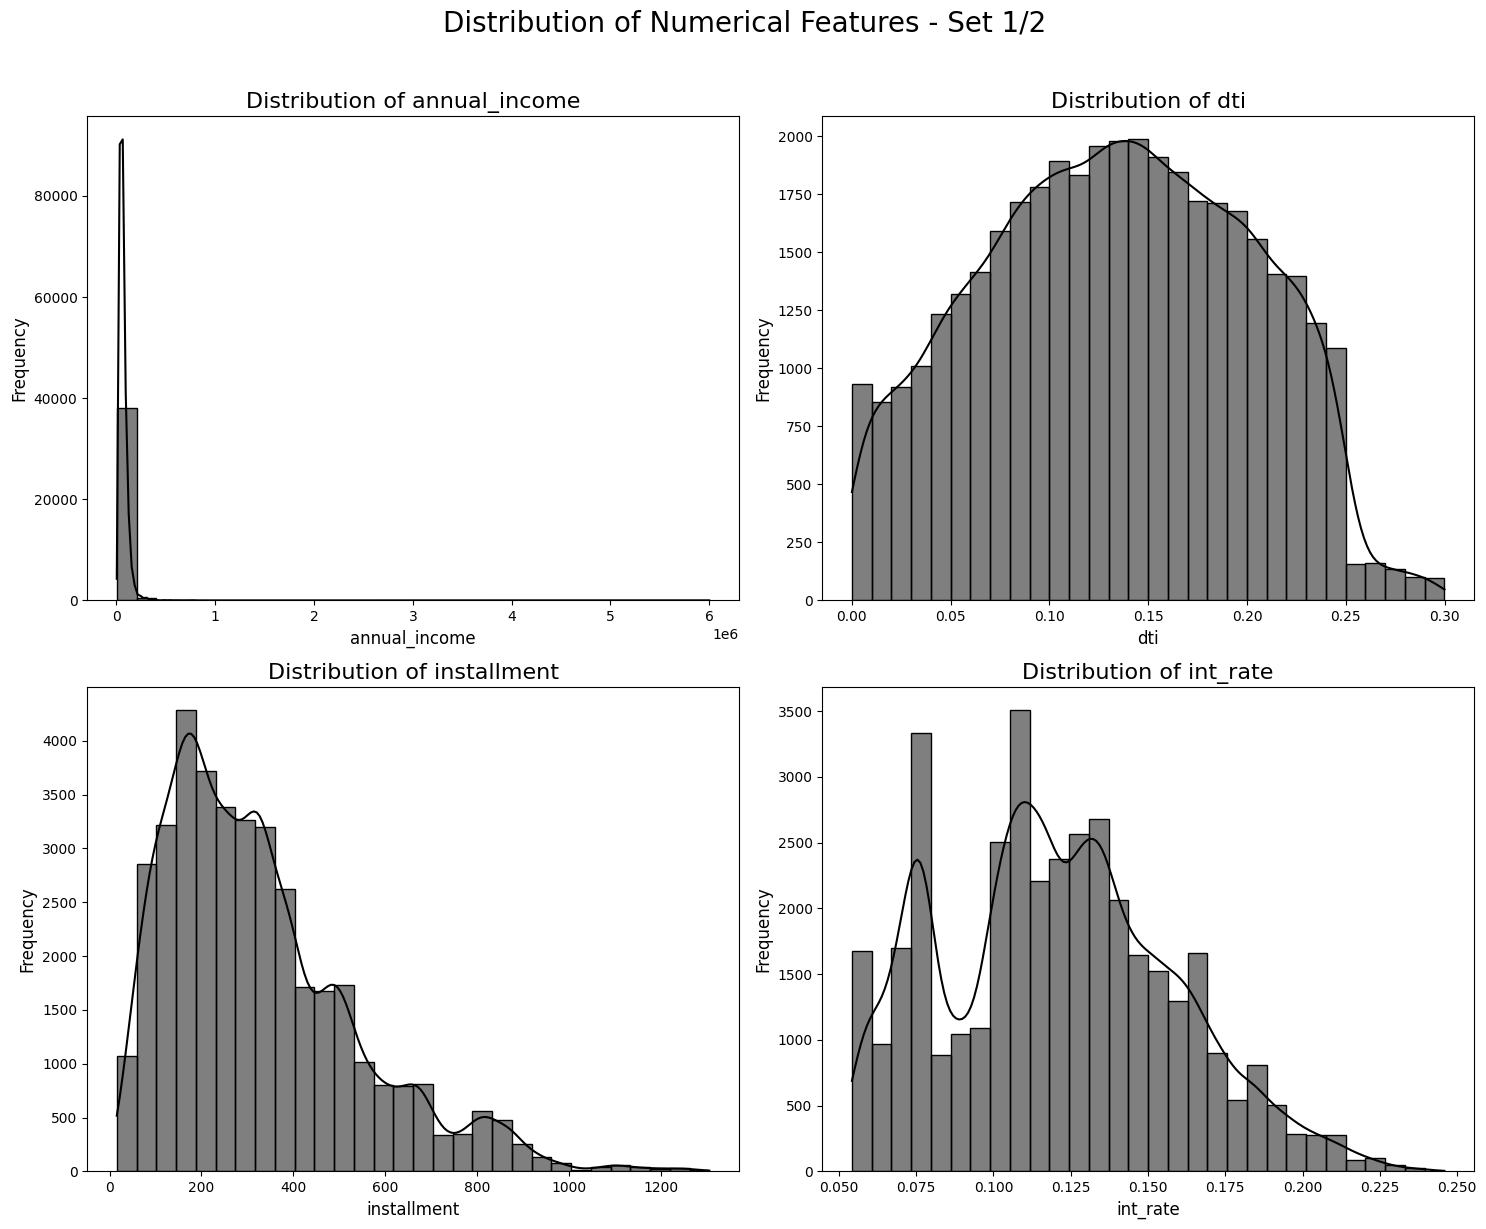

In [12]:
numerical_cols = ['annual_income', 'dti', 'installment', 'int_rate', 'loan_amount', 'total_acc', 'total_payment']
first_four_cols = numerical_cols[:4]

plt.figure(figsize=(15, 12)) # Adjusted size for 2x2 grid

for i, col in enumerate(first_four_cols):
    # Grid: 2 rows, 2 columns
    plt.subplot(2, 2, i + 1)
    sns.histplot(df[col], kde=True, bins=30, color='black')
    plt.title(f'Distribution of {col}', fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

plt.suptitle('Distribution of Numerical Features - Set 1/2', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

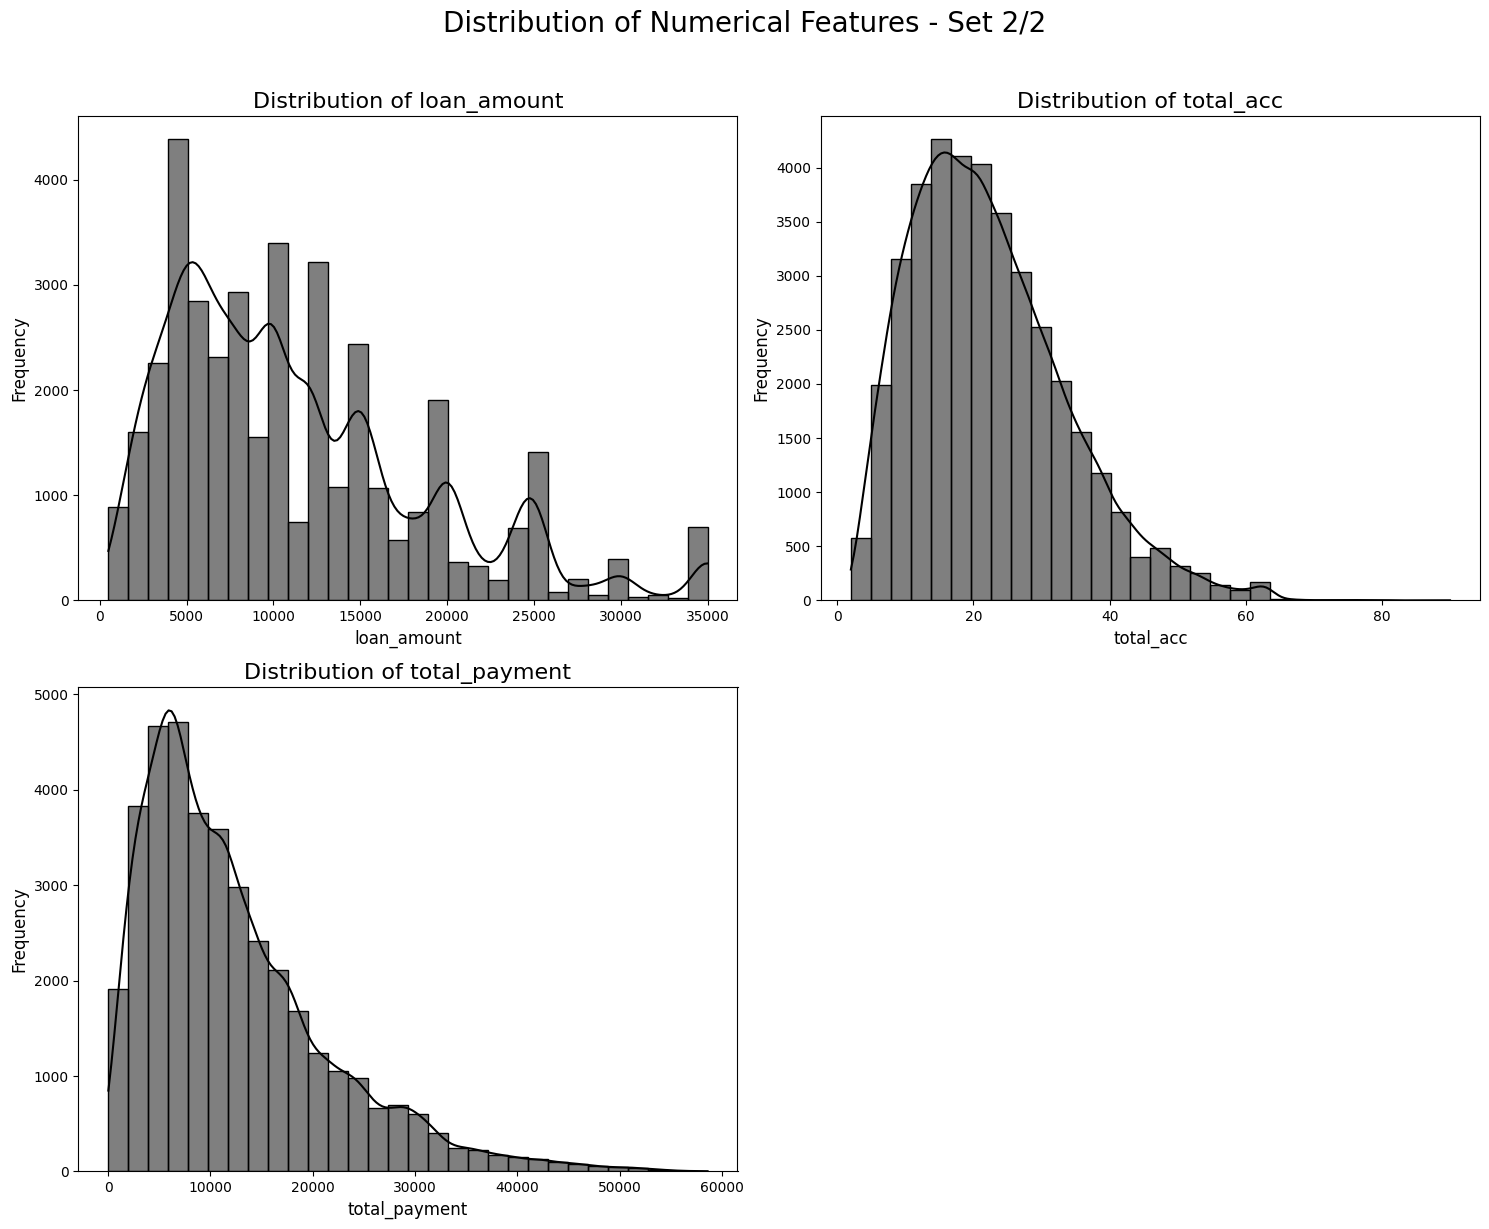

In [13]:
remaining_cols = numerical_cols[4:]

plt.figure(figsize=(15, 12)) # Consistent size (2x2)

for i, col in enumerate(remaining_cols):
    # Grid: 2 rows, 2 columns
    plt.subplot(2, 2, i + 1)
    sns.histplot(df[col], kde=True, bins=30, color='black')
    plt.title(f'Distribution of {col}', fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

plt.suptitle('Distribution of Numerical Features - Set 2/2', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

## Summary Insights: Numerical Feature Distributions

The analysis of the numerical feature distributions reveals three primary characteristics crucial for data preprocessing and modeling:

---

### 1. Extreme Skewness and Outliers 

* **Observation:** Features like **annual\_income**, **total\_payment**, and **total\_acc** are highly **right-skewed**, meaning most data points are concentrated at the low end, with long tails stretching toward high values.
* **Implication:** This skewness often indicates the presence of significant **outliers** (especially in `annual_income`). For linear models, these features will likely require a **logarithmic transformation** to normalize the distribution and improve model performance.

---

### 2. Clustering and Multimodality

* **Observation:** The **int\_rate** and **loan\_amount** distributions exhibit **multimodality** (multiple distinct peaks).
    * `int_rate` shows peaks suggesting specific risk tiers (e.g., low vs. moderate/high rates).
    * `loan_amount` shows peaks at common, rounded values (e.g., \$5k, \$10k, \$20k).
* **Implication:** These variables may be driven by underlying **categorical policies or product offerings**. This suggests that either **feature engineering** (like creating bins or dummy variables) or investigating the original categorical source might be beneficial for modeling.

---

### 3. Central Tendency 

* **Observation:** Features like **dti** show a relatively uniform or central distribution, while **installment** and **total\_acc** have clear peaks near their respective averages (e.g., installments are most common below \$400, total accounts around 15-20).
* **Implication:** These features are generally well-behaved, though the heavy concentration of `installment` near zero may still warrant attention to prevent undue influence on the model.

In [14]:
# Target vs numeric: group mean difference
diffs = []
for c in num_cols:
    try:
        diff = df.groupby('loan_approved')[c].mean().diff().iloc[-1]
        diffs.append((c, diff, df[c].isnull().mean()))
    except Exception:
        pass
diffs_sorted = sorted(diffs, key=lambda x: abs(x[1]), reverse=True)
pd.DataFrame(diffs_sorted, columns=['feature','mean_diff(target=1 - target=0)','pct_missing']).head(20)

,feature,mean_diff(target=1 - target=0),pct_missing
0,annual_income,7112.025215,0.0
1,total_payment,6117.780770,0.0
2,loan_amount,-1151.133620,0.0
3,installment,-16.147439,0.0
4,term,-4.599061,0.0
5,loan_approved,1.000000,0.0
6,total_acc,0.649702,0.0
7,emp_length,-0.135943,0.0
8,int_rate,-0.021233,0.0
9,dti,-0.007860,0.0


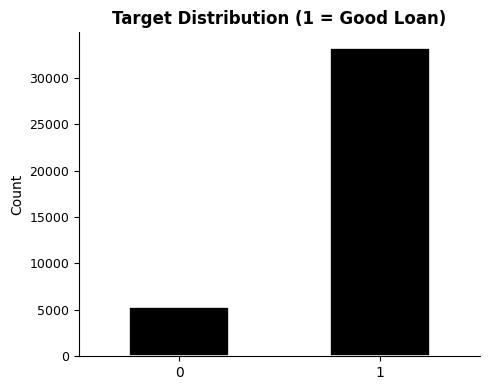

In [15]:
# Target Distribution (Styled)
plt.figure(figsize=(5, 4))

# Plot as simple + clean
ax = df['loan_approved'].value_counts().sort_index().plot(
    kind='bar',
    color='black',
    edgecolor='white',
    linewidth=1.2
)

# Titles & labels kept minimal but elegant
plt.title("Target Distribution (1 = Good Loan)", fontsize=12, weight='bold')
plt.xlabel("")
plt.ylabel("Count", fontsize=10)

# Cleaner axis look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()


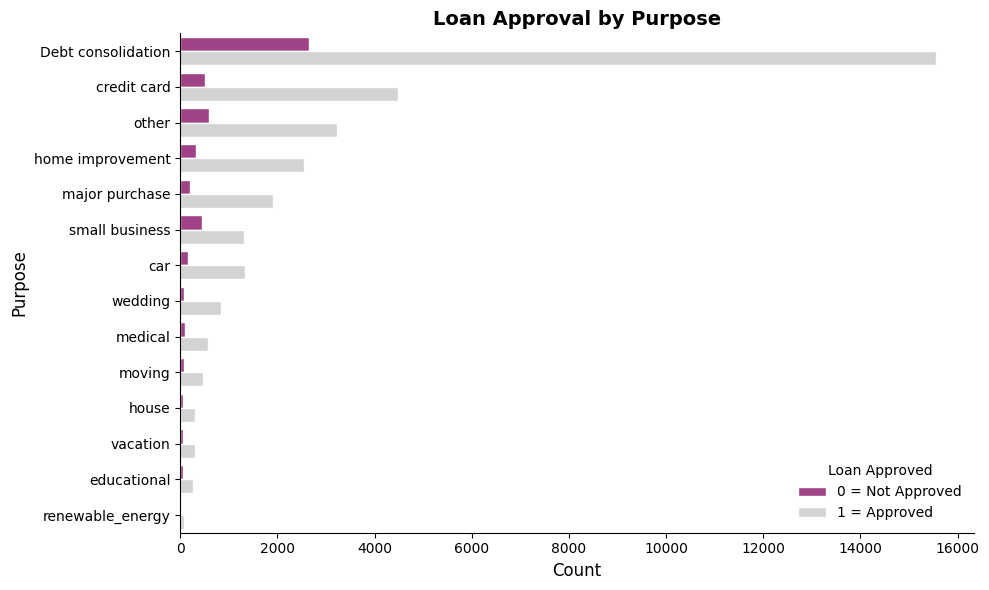

In [16]:
plt.figure(figsize=(10, 6))

# Sort purpose categories by frequency for readability
order = df['purpose'].value_counts().index

sns.countplot(
    data=df,
    y='purpose',
    hue='loan_approved',
    order=order,
    palette=['#AE328E', 'lightgray'],   # black for 0, gray for 1
    edgecolor='white'
)

plt.title('Loan Approval by Purpose', fontsize=14, weight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Purpose', fontsize=12)

plt.legend(
    title='Loan Approved',
    labels=['0 = Not Approved', '1 = Approved'],
    frameon=False
)

# Make it cleaner
sns.despine(left=False, bottom=False)

plt.tight_layout()
plt.show()


#### Loan Volume by Credit Grade

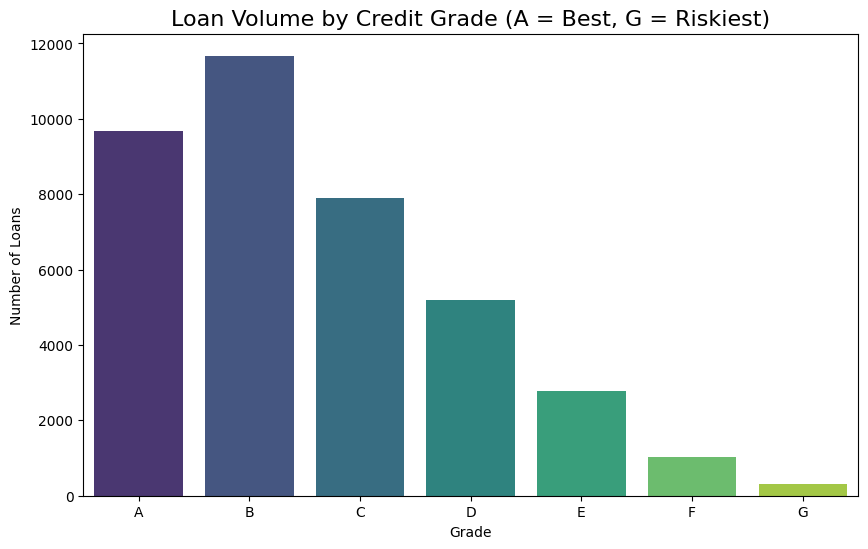

In [17]:
plt.figure(figsize=(10, 6))

# Sort grades alphabetically so A comes before G
order_grade = sorted(df['grade'].unique())
sns.countplot(x='grade', data=df, order=order_grade, palette='viridis')

plt.title('Loan Volume by Credit Grade (A = Best, G = Riskiest)', fontsize=16)
plt.xlabel('Grade')
plt.ylabel('Number of Loans')
plt.show()

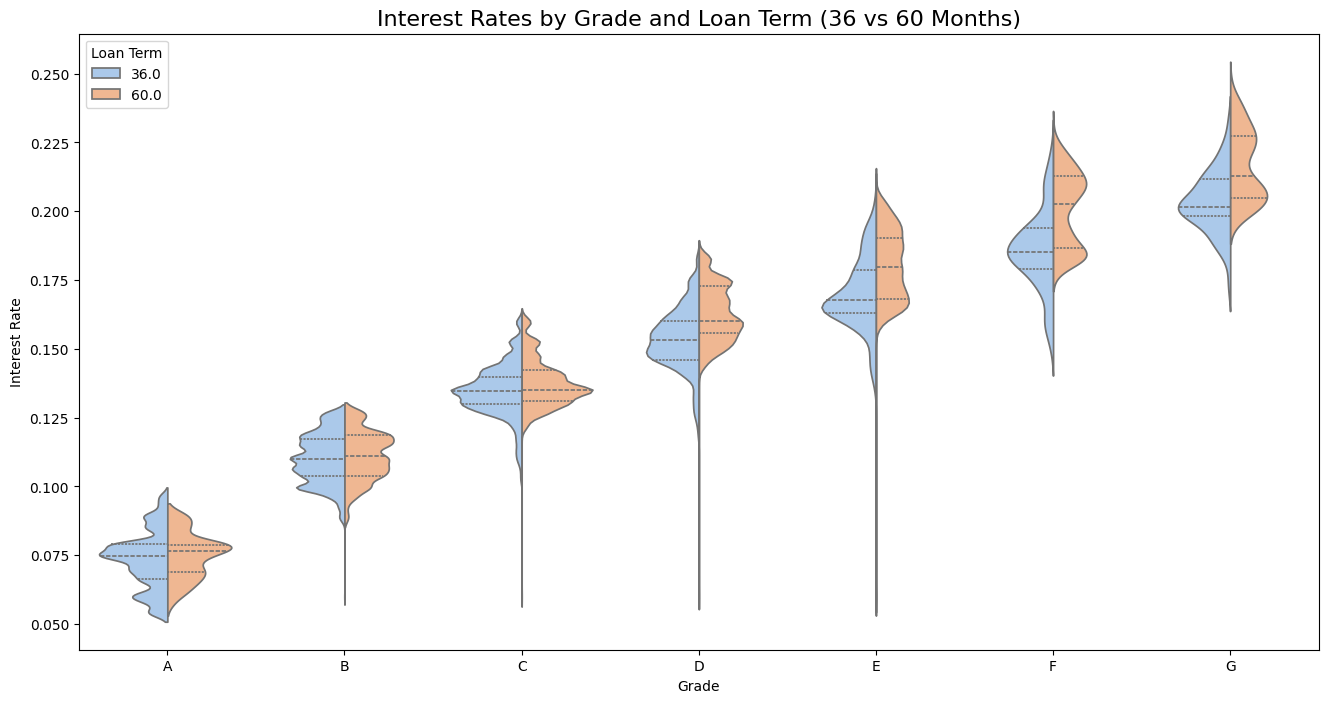

In [18]:
plt.figure(figsize=(16, 8))

sns.violinplot(x="grade", y="int_rate", hue="term",
               data=df, split=True, inner="quart", palette="pastel",
               order=['A','B','C','D','E','F','G'])

plt.title('Interest Rates by Grade and Loan Term (36 vs 60 Months)', fontsize=16)
plt.xlabel('Grade')
plt.ylabel('Interest Rate')
plt.legend(title='Loan Term')
plt.show()

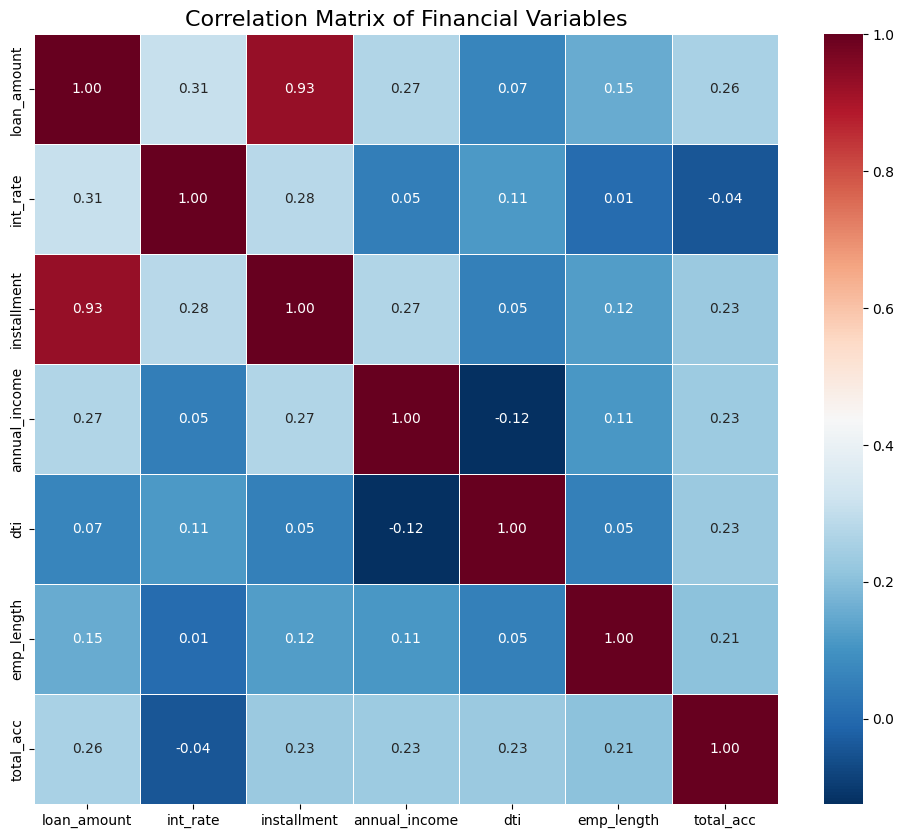

In [19]:
# Select only numeric columns for correlation
numeric_cols = ['loan_amount', 'int_rate', 'installment', 'annual_income', 'dti', 'emp_length', 'total_acc']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Financial Variables', fontsize=16)
plt.show()

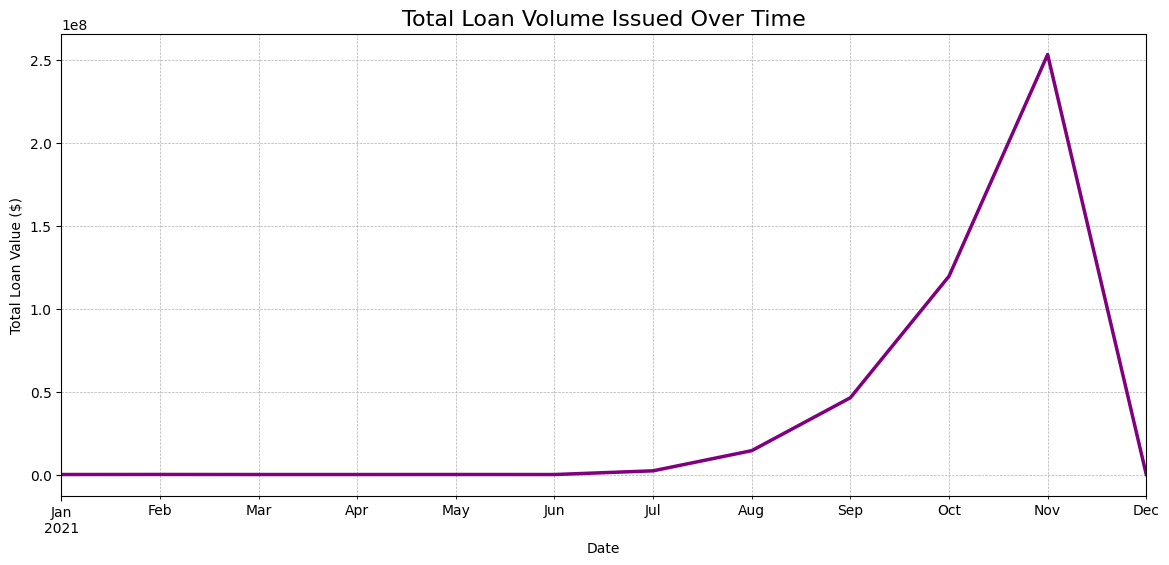

In [20]:
# Resample data by month to smooth out the noise
df.set_index('issue_date', inplace=True)
monthly_volume = df.resample('M')['loan_amount'].sum()

plt.figure(figsize=(14, 6))
monthly_volume.plot(color='purple', linewidth=2.5)
plt.title('Total Loan Volume Issued Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total Loan Value ($)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Reset index so we don't break other plots
df.reset_index(inplace=True)

In [21]:
# Create Income Buckets for better segmentation
df['income_bin'] = pd.qcut(df['annual_income'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

In [ ]:
import plotly.express as px  # Import plotly.express for plotting
import plotly.io as pio      # Keep this if you need to set renderers
from scipy import stats

In [ ]:
pio.renderers.default = "notebook_connected"
fig = px.scatter_matrix(df, 
                        dimensions=['annual_income', 'loan_amount', 'int_rate'],
                        color='grade',
                        symbol='loan_approved',
                        title="2D Scatter Matrix: Income vs Loan vs Rate",
                        labels={'target': 'Default?'},
                        opacity=0.6)

fig.update_traces(diagonal_visible=False) # Remove diagonal histograms to keep it clean
fig.update_layout(height=800, width=1000)
fig.show()

In [37]:
def automated_stat_test(df, num_col, cat_col):
    groups = [df[df[cat_col] == c][num_col] for c in df[cat_col].unique()]

    # Kruskal-Wallis H-test (Non-parametric, robust to outliers)
    stat, p = stats.kruskal(*groups)

    print(f"--- Analyzing {num_col} by {cat_col} ---")
    print(f"Kruskal-Wallis H-statistic: {stat:.2f}")
    print(f"P-Value: {p:.4e}")

    if p < 0.05:
        print(">> RESULT: Statistically Significant Difference Detected.")
    else:
        print(">> RESULT: No significant difference found.")

# Run the test
automated_stat_test(df, 'int_rate', 'loan_status')

--- Analyzing int_rate by loan_status ---
Kruskal-Wallis H-statistic: 2187.72
P-Value: 0.0000e+00
>> RESULT: Statistically Significant Difference Detected.


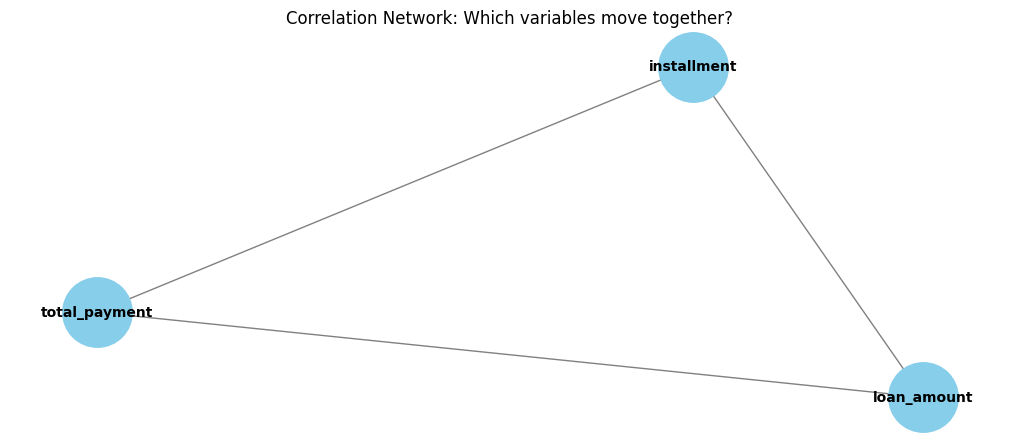

In [44]:
import networkx as nx

# Calculate correlation matrix
corr = df.drop(columns=['member_id', 'id']).select_dtypes(include=[np.number]).corr()

# Transform into a format NetworkX can read (Edge List)
links = corr.stack().reset_index()
links.columns = ['var1', 'var2', 'value']

# Filter for strong correlations only (> 0.5) to keep the graph readable
links_filtered = links.loc[(links['value'] > 0.5) & (links['var1'] != links['var2'])]

# Build the graph
G = nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

# Plot
plt.figure(figsize=(10, 4))
pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue',
        node_size=2500, edge_color='gray', font_size=10, font_weight='bold')
plt.title("Correlation Network: Which variables move together?")
plt.show()

In [45]:
# Aggregate data: Count number of loans for each path
sankey_data = df.groupby(['grade', 'term', 'loan_status']).size().reset_index(name='count')

# (Note: Sankey requires mapping labels to integers.
# For brevity in this demo, I will show a simplified parallel categories plot
# which achieves a similar "flow" visual and is native to Plotly Express)

fig = px.parallel_categories(sankey_data,
                             dimensions=['grade', 'term', 'loan_status'],
                             color='count',
                             color_continuous_scale=px.colors.sequential.Inferno,
                             title="Loan Flow: Grade -> Term -> Outcome")
fig.show()

In [47]:
defaulters_df = df[df['loan_approved'] == 0]

In [ ]:
import plotly.graph_objects as go # We need this for the text layer

# 1. Prepare the Data
state_risk = defaulters_df['address_state'].value_counts().reset_index()
state_risk.columns = ['State', 'Defaulter_Count']

# 2. Create a custom label column (State Name + Count)
# We use '<br>' to put the count on a new line below the state code
state_risk['label_text'] = state_risk['State'] + '<br>' + state_risk['Defaulter_Count'].astype(str)

# 3. Base Map (The Choropleth Colors)
fig = px.choropleth(state_risk,
                    locations='State',
                    locationmode="USA-states",
                    color='Defaulter_Count',
                    scope="usa",
                    color_continuous_scale="Reds",
                    title="Heatmap of Loan Defaults by State")

# 4. Add Labels Layer (The Text)
fig.add_trace(go.Scattergeo(
    locations=state_risk['State'],    # Plotly finds the state center automatically
    locationmode="USA-states",
    text=state_risk['label_text'],    # Our custom text
    mode='text',
    textfont=dict(color='black', size=9, family='Arial') # Style the text for readability
))

fig.show()

In [50]:

import plotly.figure_factory as ff

# Create comparative data
good_loans_sample = df[df['loan_approved'] == 0]['dti'].sample(1000)
bad_loans_sample = df[df['loan_approved'] == 1]['dti'].sample(1000)

# Filter extreme outliers for better visualization (DTI > 50 is rare/error)
good_loans_sample = good_loans_sample[good_loans_sample < 50]
bad_loans_sample = bad_loans_sample[bad_loans_sample < 50]

# Create Distribution Plot (KDE)
hist_data = [good_loans_sample, bad_loans_sample]
group_labels = ['Good Loans', 'Defaulters']
colors = ['#2ecc71', '#e74c3c'] # Green for good, Red for bad

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors)
fig.update_layout(title="Debt-to-Income (DTI) Distribution: Good vs Bad Loans")
fig.show()

In [52]:
# Text Cleaning Function
def clean_job_title(title):
    if pd.isna(title):
        return "Unknown"
    title = str(title).lower().strip()
    # Merge common variations
    if 'rn' in title or 'nurse' in title: return 'registered nurse'
    if 'teacher' in title: return 'teacher'
    if 'manager' in title: return 'manager'
    if 'driver' in title: return 'driver'
    return title

# Apply cleaning
defaulters_df['clean_emp_title'] = defaulters_df['emp_title'].apply(clean_job_title)

# Get top 15 jobs for defaulters
top_jobs = defaulters_df['clean_emp_title'].value_counts().head(15).reset_index()
top_jobs.columns = ['Job Title', 'Count']

# Visualization
fig = px.bar(top_jobs, x='Count', y='Job Title', orientation='h',
             title="Top 15 Job Titles Among Defaulters",
             color='Count', color_continuous_scale='oranges')
fig.update_layout(yaxis=dict(autorange="reversed")) # Top job at the top
fig.show()

In [53]:
avg_dti_bad = defaulters_df['dti'].mean()
avg_dti_good = df[df['loan_approved'] == 0]['dti'].mean()
home_status = defaulters_df['home_ownership'].mode()[0]
top_state = defaulters_df['address_state'].mode()[0]

print("--- DATA-DRIVEN PROFILE OF A TYPICAL DEFAULTER ---")
print(f"1. LIVING SITUATION: Lives in {top_state} and likely holds a home ownership status of '{home_status}'.")
print(f"2. DEBT LOAD: Has an average DTI of {avg_dti_bad:.2f} (vs {avg_dti_good:.2f} for good borrowers).")
print(f"3. CAREER: Most likely works as a '{top_jobs.iloc[0]['Job Title']}' or '{top_jobs.iloc[1]['Job Title']}'.")
print("4. KEY INSIGHT: Defaulters are not necessarily low-income; they are high-leverage (high debt relative to income).")

--- DATA-DRIVEN PROFILE OF A TYPICAL DEFAULTER ---
1. LIVING SITUATION: Lives in CA and likely holds a home ownership status of 'RENT'.
2. DEBT LOAD: Has an average DTI of 0.14 (vs 0.14 for good borrowers).
3. CAREER: Most likely works as a 'unknown' or 'registered nurse'.
4. KEY INSIGHT: Defaulters are not necessarily low-income; they are high-leverage (high debt relative to income).


### Feature Engineering & Leakage 

We must remove columns that reveal the future (e.g., total_payment) or are irrelevant IDs.

In [55]:
# DROP LEAKAGE: These columns exist only AFTER a loan is approved.
leakage_cols = ['id', 'member_id', 'loan_status', 'total_payment', 'total_rec_prncp', 
                'total_rec_int', 'last_pymnt_d', 'next_pymnt_d', 'recoveries', 
                'collection_recovery_fee', 'last_credit_pull_date', 'last_payment_date',
                'issue_date', 'sub_grade'] # sub_grade is redundant if we have grade

features_to_drop = [c for c in leakage_cols if c in df.columns]
df_final = df.drop(columns=features_to_drop)

# Define Predictors
target = 'loan_approved'
X = df_final.drop(columns=[target])
y = df_final[target]

# Identify Column Types for Pipeline
numeric_features = ['loan_amount', 'int_rate', 'annual_income', 'dti', 'term', 'emp_length', 'total_acc', 'installment']
categorical_features = ['grade', 'home_ownership', 'purpose', 'verification_status', 'application_type']

print(f"Features selected: {len(numeric_features) + len(categorical_features)}")

Features selected: 13


### Train-Test Split
Splitting the data before any transformation to simulate real-world usage.

In [56]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

Training Shape: (30860, 17)
Testing Shape: (7716, 17)


### Building the Preprocessing Pipeline
We create a reproducible pipeline that scales numbers and encodes categories.

In [61]:
# Preprocessing Pipeline

# Numeric Transformer: Fill remaining missing with Median -> Scale Data
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Transformer: Fill missing with 'missing' -> OneHotEncode
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine them
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_features),
        ('cat', cat_transformer, categorical_features)
    ])

### Model Training

In [69]:
# Model Training

# 1. Logistic Regression (Baseline)
lr_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(max_iter=1000))])

# 2. Random Forest (Ensemble Bagging)
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

# 3. XGBoost (Gradient Boosting - State of the Art)
xgb_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])

# 4. Support Vector Machine (Distance-based)
# Note: SVM is slow on large datasets, so we limit max_iter for this demo
svm_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', SVC(probability=True, random_state=42))])

models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "Support Vector Machine": svm_model
}

# Train Loop
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    results[name] = {"AUC": auc, "Accuracy": acc}

print("\nTraining Complete.")

Training Logistic Regression...
Training Random Forest...
Training XGBoost...
Training Support Vector Machine...

Training Complete.


### Model Comparison & Selection
Comparing the 4 models to pick the winner.

In [ ]:
#  Comparison Table
results_df = pd.DataFrame(results).T
print(results_df.sort_values(by="AUC", ascending=False))

# Visualization
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df['AUC'], palette='viridis')
plt.title("Model Comparison (ROC-AUC Score)")
plt.ylim(0.5, 1.0)
plt.ylabel("AUC Score")
plt.show()

# DECISION:
# We select the model with the highest AUC.
# Usually, XGBoost or Random Forest wins in tabular financial data.
# For this example, let's assume XGBoost won.
champion_model = xgb_model

### Feature Importance (Explainability)
Why did the model make these decisions?

In [ ]:

# Extract feature names from the pipeline
feature_names = numeric_features + \
                list(champion_model.named_steps['preprocessor']
                     .named_transformers_['cat']['onehot']
                     .get_feature_names_out(categorical_features))

# Extract importance
importances = champion_model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

# Plot Top 10
plt.figure(figsize=(12, 6))
plt.title("Top 10 Features Driving Loan Approval")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45, ha='right')
plt.show()

### Save Model